# **Trabalho 3 - Reconhecimento de Padrões**
### Classificadores Bayesianos
##### Renan Henrique Cardoso - 379013

In [1]:
import pandas as pd
import numpy
import seaborn as sns
import matplotlib.pyplot as plt

derma = pd.read_csv("https://raw.githubusercontent.com/cardosorrenan/reconhecimentopadroes-ufc/master/datasets/dermatology.csv")
derma.columns = ['erythema', 'scaling', 'def_borders', 'itching', 'koebner_phen', 'poly_papules',
                 'fol_papules', 'oral_muc_inv', 'knee_elbow_inv', 'scalp_inv', 'family_history',
                 'melanin_incont', 'eos_infiltrate', 'pnl_infiltrate', 'fibrosis_papil_derm', 
                 'exocytosis', 'acanthosis', 'hyperkeratosis', 'parakeratosis', 'club_rete_ridges', 
                 'elong_rete_ridges', 'thinning_supra_epid', 'spongiform_pustule', 'munro_microabcess', 
                 'focal_hypergran', 'dis_granular_layer', 'vac_damage_basal', 'spongiosis', 'saw_tooth_retes', 
                 'fol_horn_plug', 'perifol_parakeratosis', 'inflam_mono_inf', 'band_like_inf', 'age', 'class']

global_average_age = 29.6
global_average_age = round(global_average_age, 0)
derma['age'] = pd.to_numeric(derma['age'], errors='coerce').fillna(global_average_age) # Substitui os ? pela média global

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
derma.head()

,erythema,scaling,def_borders,itching,koebner_phen,poly_papules,fol_papules,oral_muc_inv,knee_elbow_inv,scalp_inv,family_history,melanin_incont,eos_infiltrate,pnl_infiltrate,fibrosis_papil_derm,exocytosis,acanthosis,hyperkeratosis,parakeratosis,club_rete_ridges,elong_rete_ridges,thinning_supra_epid,spongiform_pustule,munro_microabcess,focal_hypergran,dis_granular_layer,vac_damage_basal,spongiosis,saw_tooth_retes,fol_horn_plug,perifol_parakeratosis,inflam_mono_inf,band_like_inf,age,class
0,3,3,3,2,1,0,0,0,1,1,1,0,0,1,0,1,2,0,2,2,2,2,2,1,0,0,0,0,0,0,0,1,0,8.0,1
1,2,1,2,3,1,3,0,3,0,0,0,1,0,0,0,1,2,0,2,0,0,0,0,0,2,0,2,3,2,0,0,2,3,26.0,3
2,2,2,2,0,0,0,0,0,3,2,0,0,0,3,0,0,2,0,3,2,2,2,2,0,0,3,0,0,0,0,0,3,0,40.0,1
3,2,3,2,2,2,2,0,2,0,0,0,1,0,0,0,1,2,0,0,0,0,0,0,0,2,2,3,2,3,0,0,2,3,45.0,3
4,2,3,2,0,0,0,0,0,0,0,0,0,2,1,0,2,2,0,2,0,0,0,1,0,0,0,0,2,0,0,0,1,0,41.0,2


### **Análise inicial dos dados**

- Vetor médio

In [3]:
mean_vector = pd.DataFrame(derma.mean()).T
mean_vector

,erythema,scaling,def_borders,itching,koebner_phen,poly_papules,fol_papules,oral_muc_inv,knee_elbow_inv,scalp_inv,family_history,melanin_incont,eos_infiltrate,pnl_infiltrate,fibrosis_papil_derm,exocytosis,acanthosis,hyperkeratosis,parakeratosis,club_rete_ridges,elong_rete_ridges,thinning_supra_epid,spongiform_pustule,munro_microabcess,focal_hypergran,dis_granular_layer,vac_damage_basal,spongiosis,saw_tooth_retes,fol_horn_plug,perifol_parakeratosis,inflam_mono_inf,band_like_inf,age,class
0,2.068493,1.794521,1.553425,1.361644,0.635616,0.449315,0.167123,0.378082,0.613699,0.520548,0.126027,0.405479,0.139726,0.547945,0.336986,1.364384,1.956164,0.528767,1.293151,0.665753,0.994521,0.635616,0.29589,0.364384,0.394521,0.465753,0.457534,0.947945,0.454795,0.10411,0.115068,1.868493,0.556164,36.106849,2.805479


- Vetor de variâncias 

In [4]:
variance_vector = pd.DataFrame(derma.var()).T
variance_vector

,erythema,scaling,def_borders,itching,koebner_phen,poly_papules,fol_papules,oral_muc_inv,knee_elbow_inv,scalp_inv,family_history,melanin_incont,eos_infiltrate,pnl_infiltrate,fibrosis_papil_derm,exocytosis,acanthosis,hyperkeratosis,parakeratosis,club_rete_ridges,elong_rete_ridges,thinning_supra_epid,spongiform_pustule,munro_microabcess,focal_hypergran,dis_granular_layer,vac_damage_basal,spongiosis,saw_tooth_retes,fol_horn_plug,perifol_parakeratosis,inflam_mono_inf,band_like_inf,age,class
0,0.443098,0.493376,0.819253,1.291931,0.825651,0.91844,0.326389,0.69732,0.968493,0.821692,0.110447,0.758212,0.169983,0.665964,0.729535,1.215761,0.509062,0.574033,0.839651,1.118742,1.351618,1.072904,0.45067,0.578398,0.723047,0.749511,0.913714,1.269261,0.913473,0.203417,0.23947,0.526614,1.225546,230.20009,2.558212


- Matriz de covariância e matriz de correlação

In [5]:
%%time
def create_matrices():
  attrs = derma.columns.to_list()
  n_attrs = len(attrs)
  mtrx_cov = numpy.zeros(shape=(n_attrs, n_attrs))
  mtrx_corr = numpy.zeros(shape=(n_attrs, n_attrs))
  for i in range(0, n_attrs):
    for j in range(i, n_attrs):
      sum_attr1 = derma.apply(lambda row: row[attrs[i]] - mean_vector[attrs[i]], axis=1)
      sum_attr2 = derma.apply(lambda row: row[attrs[j]] - mean_vector[attrs[j]], axis=1)
      cov = (sum_attr1 * sum_attr2).sum() / (derma.shape[0] - 1)
      corr = cov / (derma[attrs[i]].std() * derma[attrs[j]].std())
      mtrx_cov[i,j] = mtrx_cov[j,i] = cov
      mtrx_corr[i,j] = mtrx_corr[j,i] = corr
      
  
  df_cov = pd.DataFrame(mtrx_cov, index=attrs, columns=attrs)
  df_corr = pd.DataFrame(mtrx_corr, index=attrs, columns=attrs)
  return df_cov, df_corr

# cov, corr = create_matrices()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


obs: apesar da função acima implementada funcionar corretamente, não está otimizada para encontrar as matrizes desejadas entre os 34 atributos de entrada. Tempo de execução: 140s ~ 150s

In [6]:
derma.cov().head()

,erythema,scaling,def_borders,itching,koebner_phen,poly_papules,fol_papules,oral_muc_inv,knee_elbow_inv,scalp_inv,family_history,melanin_incont,eos_infiltrate,pnl_infiltrate,fibrosis_papil_derm,exocytosis,acanthosis,hyperkeratosis,parakeratosis,club_rete_ridges,elong_rete_ridges,thinning_supra_epid,spongiform_pustule,munro_microabcess,focal_hypergran,dis_granular_layer,vac_damage_basal,spongiosis,saw_tooth_retes,fol_horn_plug,perifol_parakeratosis,inflam_mono_inf,band_like_inf,age,class
erythema,0.443098,0.203673,0.157045,-0.035827,0.000301,0.021338,-0.041698,-0.014978,0.092466,0.112600,0.038048,0.024349,0.020623,0.121707,-0.201716,0.016182,0.030483,-0.028075,0.128218,0.110869,0.005871,0.115686,0.075832,0.057391,-0.007865,0.091638,0.001543,0.017311,-0.003763,-0.001656,0.003086,0.036505,-0.005231,0.014639,-0.357519
scaling,0.203673,0.493376,0.229414,-0.068343,-0.006398,-0.050278,-0.036994,-0.048472,0.206119,0.192421,0.042451,-0.045574,0.012306,0.162351,-0.230017,-0.087009,0.054155,0.007301,0.192270,0.238823,0.114256,0.240855,0.140637,0.099804,-0.050580,0.128933,-0.073310,0.008505,-0.076622,-0.003274,-0.003763,-0.005118,-0.102439,0.233554,-0.526344
def_borders,0.157045,0.229414,0.819253,-0.057835,0.196718,0.283622,-0.087250,0.216009,0.272068,0.219366,0.034457,0.244761,-0.050068,0.028338,-0.214481,-0.199466,0.123227,0.027992,0.296109,0.369554,0.209085,0.345070,0.148984,0.165919,0.223370,0.277247,0.257083,-0.254079,0.236625,-0.035797,-0.055615,0.070232,0.282019,2.083562,-0.573370
itching,-0.035827,-0.068343,-0.057835,1.291931,0.280491,0.449699,-0.093572,0.343663,-0.337935,-0.158550,-0.051197,0.358453,0.045484,-0.132771,0.199225,0.263465,0.054358,-0.004938,-0.073340,-0.277141,-0.160101,-0.285443,-0.115543,-0.046974,0.354185,-0.188130,0.402762,0.013383,0.411998,-0.089952,-0.102168,0.055931,0.490622,0.664549,0.103507
koebner_phen,0.000301,-0.006398,0.196718,0.280491,0.825651,0.342744,-0.090035,0.297486,-0.058731,0.011629,-0.025380,0.304749,-0.017628,-0.126712,-0.192804,0.149624,-0.035248,0.000896,-0.032997,0.006992,-0.175079,0.023453,-0.001776,0.108415,0.308987,0.002597,0.326517,-0.002537,0.331010,-0.060861,-0.073340,0.053598,0.384533,1.159920,-0.134262


In [7]:
corr = derma.corr()
corr.head()

,erythema,scaling,def_borders,itching,koebner_phen,poly_papules,fol_papules,oral_muc_inv,knee_elbow_inv,scalp_inv,family_history,melanin_incont,eos_infiltrate,pnl_infiltrate,fibrosis_papil_derm,exocytosis,acanthosis,hyperkeratosis,parakeratosis,club_rete_ridges,elong_rete_ridges,thinning_supra_epid,spongiform_pustule,munro_microabcess,focal_hypergran,dis_granular_layer,vac_damage_basal,spongiosis,saw_tooth_retes,fol_horn_plug,perifol_parakeratosis,inflam_mono_inf,band_like_inf,age,class
erythema,1.000000,0.435607,0.260654,-0.047353,0.000498,0.033449,-0.109647,-0.026946,0.141151,0.186609,0.171989,0.042008,0.075146,0.224048,-0.354787,0.022048,0.064184,-0.055667,0.210208,0.157469,0.007586,0.167784,0.169696,0.113366,-0.013896,0.159014,0.002425,0.023084,-0.005915,-0.005515,0.009474,0.075570,-0.007099,0.001450,-0.335800
scaling,0.435607,1.000000,0.360846,-0.085602,-0.010024,-0.074691,-0.092188,-0.082639,0.298182,0.302209,0.181852,-0.074514,0.042494,0.283231,-0.383395,-0.112344,0.108059,0.013719,0.298726,0.321456,0.139914,0.331044,0.298250,0.186830,-0.084684,0.212024,-0.109187,0.010748,-0.114134,-0.010335,-0.010949,-0.010041,-0.131738,0.021915,-0.468502
def_borders,0.260654,0.360846,1.000000,-0.056217,0.239187,0.326968,-0.168728,0.285790,0.305436,0.267366,0.114550,0.310555,-0.134167,0.038365,-0.277433,-0.199864,0.190815,0.040818,0.357020,0.386015,0.198695,0.368059,0.245189,0.241031,0.290224,0.353809,0.297138,-0.249164,0.273529,-0.087689,-0.125562,0.106925,0.281452,0.151721,-0.396057
itching,-0.047353,-0.085602,-0.056217,1.000000,0.271582,0.412835,-0.144099,0.362073,-0.302110,-0.153884,-0.135533,0.362174,0.097059,-0.143139,0.205211,0.210223,0.067028,-0.005734,-0.070416,-0.230524,-0.121157,-0.242449,-0.151424,-0.054341,0.366460,-0.191183,0.370701,0.010451,0.379251,-0.175467,-0.183683,0.067809,0.389908,0.038535,0.056936
koebner_phen,0.000498,-0.010024,0.239187,0.271582,1.000000,0.393592,-0.173438,0.392060,-0.065678,0.014118,-0.084046,0.385167,-0.047053,-0.170882,-0.248425,0.149341,-0.054368,0.001301,-0.039630,0.007275,-0.165733,0.024919,-0.002912,0.156883,0.399907,0.003301,0.375926,-0.002478,0.381149,-0.148507,-0.164937,0.081283,0.382270,0.084135,-0.092382


- Que informação, sobre os atributos, é obtida através da matriz de correlação?

O diagrama de correlação auxilia em determinar a relação (-1 < corr < 1) entre os atributos, podemos observar melhor atráves de um mapa de calor todas essas conexões de causa e efeito entre os dados, sendo assim, dele podemos extrair quais são os atributos que possuem uma 'forte conexão':

- saw_tooth_retes / vac_damage_basal = 0.938359
- fol_horn_plug / perifol_parakeratosis = 0.928918
- saw_tooth_retes / band_like_inf = 0.928703
- melanin_incont / poly_papules = 0.906988
- focal_hypergran / band_like_inf = 0.904460


    - saw_tooth_retes: Aspecto "dente-de-serra" das cristas interpapilares
    - vac_damage_basal: Vacuolização e destruição da camada basal
    - fol_horn_plug: Tampões cárneos foliculares
    - perifol_parakeratosis: Paraceratose perifolicular
    - band_like_inf: Infiltrado em banda
    - melanin_incont: Incontinência de melanina
    - poly_papules: Pápulas poligonais
    - focal_hypergran: Hipergranulose focal

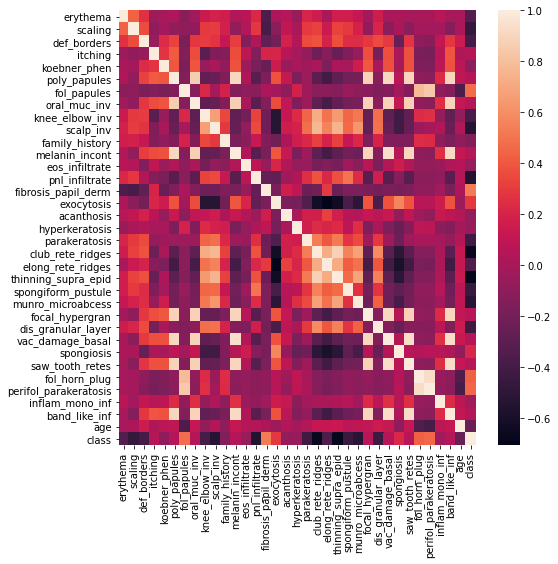

In [8]:
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
plt.gcf().set_size_inches(8, 8)

### **Classificadores Bayesianos**

- I) QDA 